<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/birds_tfrec_convert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!wget -O dataset.zip https://www.dropbox.com/s/xkfeugecrkqjpks/100-bird-species.zip?dl=0
!unzip -q -o dataset.zip -d dataset

--2022-11-23 10:43:34--  https://www.dropbox.com/s/xkfeugecrkqjpks/100-bird-species.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xkfeugecrkqjpks/100-bird-species.zip [following]
--2022-11-23 10:43:35--  https://www.dropbox.com/s/raw/xkfeugecrkqjpks/100-bird-species.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8eb8bfbe38737a18a3907c1381.dl.dropboxusercontent.com/cd/0/inline/BxRab9IbhfEJWMrnEcAFBub9-upJLeYXznq7k64rRoEZ9DaLql8U4Pshx8olWY9QnZ4iMo3lthqqIDPqWj50w-bEAxw97qDMlYpY--oalmJgzRe90vUbVGcVHPf1LZfNFyTq02Ajpt0bP-n2Sj8LjpC4yXSIH_Zt4e47YTFKnnOjlw/file# [following]
--2022-11-23 10:43:35--  https://uc8eb8bfbe38737a18a3907c1381.dl.dropboxusercontent.com/cd/0/inline/BxRab9IbhfEJWMrnEcAFBub9-upJLeYXznq7k64rRoEZ9DaL

In [46]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import pathlib
import numpy as np
from matplotlib import pyplot as plt
import os

DATASET_PATH = 'dataset';
TFREC_FILE = 'birds-dataset.tfrec';

text_labels = sorted([name for name in os.listdir(DATASET_PATH)])
train_data_root = pathlib.Path(DATASET_PATH)
train_images_paths = [str(path) for path in list(train_data_root.glob('*/*.jpg'))]
train_images_text_labels = [pathlib.Path(path).parent.name for path in train_images_paths]
train_images_numerical_labels = [text_labels.index(text_label) for text_label in train_images_text_labels]
train_images_onehot_labels = [to_categorical(text_labels.index(text_label), len(text_labels), dtype='int64') for text_label in train_images_text_labels]

In [47]:
def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def serialize_train_example(image, label_text, label_onehot, label_number):
  image_raw = tf.image.encode_jpeg(image)
  
  feature = {
    'image': _bytes_feature(image_raw),
    'height': _int64_feature(image.shape[0]),
    'width': _int64_feature(image.shape[1]),
    'channels': _int64_feature(image.shape[2]),
    'label_text': _bytes_feature(label_text),
    'label_onehot': tf.train.Feature(int64_list=tf.train.Int64List(value=label_onehot)),
    'label_number': _int64_feature(label_number),
  }

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [48]:
with tf.io.TFRecordWriter(TFREC_FILE) as writer:
  for image_path, label_number, text_label in zip(train_images_paths, train_images_numerical_labels, train_images_text_labels):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    label_onehot = to_categorical(text_labels.index(text_label), len(text_labels), dtype='int64') 

    writer.write(serialize_train_example(image, text_label.encode(), label_onehot, label_number))

In [49]:
def split_tfrecord(tfrecord_path, split_size):
    with tf.Graph().as_default(), tf.Session() as sess:
        ds = tf.data.TFRecordDataset(tfrecord_path).batch(split_size)
        batch = ds.make_one_shot_iterator().get_next()
        part_num = 0
        while True:
            try:
                records = sess.run(batch)
                part_path = tfrecord_path + '.{:03d}'.format(part_num)
                with tf.python_io.TFRecordWriter(part_path) as writer:
                    for record in records:
                        writer.write(record)
                part_num += 1
            except tf.errors.OutOfRangeError: break

In [52]:
def parse_example(proto):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), 
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),
    'label_text': tf.io.FixedLenFeature([], tf.string), 
    'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'label_number': tf.io.FixedLenFeature([], tf.int64),
  }

  parsed = tf.io.parse_single_example(serialized=proto, features=features)
  image, label_text = parsed["image"], parsed["label_text"]
  image = tf.image.decode_jpeg(image, channels=3)
    
  return image, label_text

tfrecord_files = tf.io.gfile.glob(TFREC_FILE)
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_example)

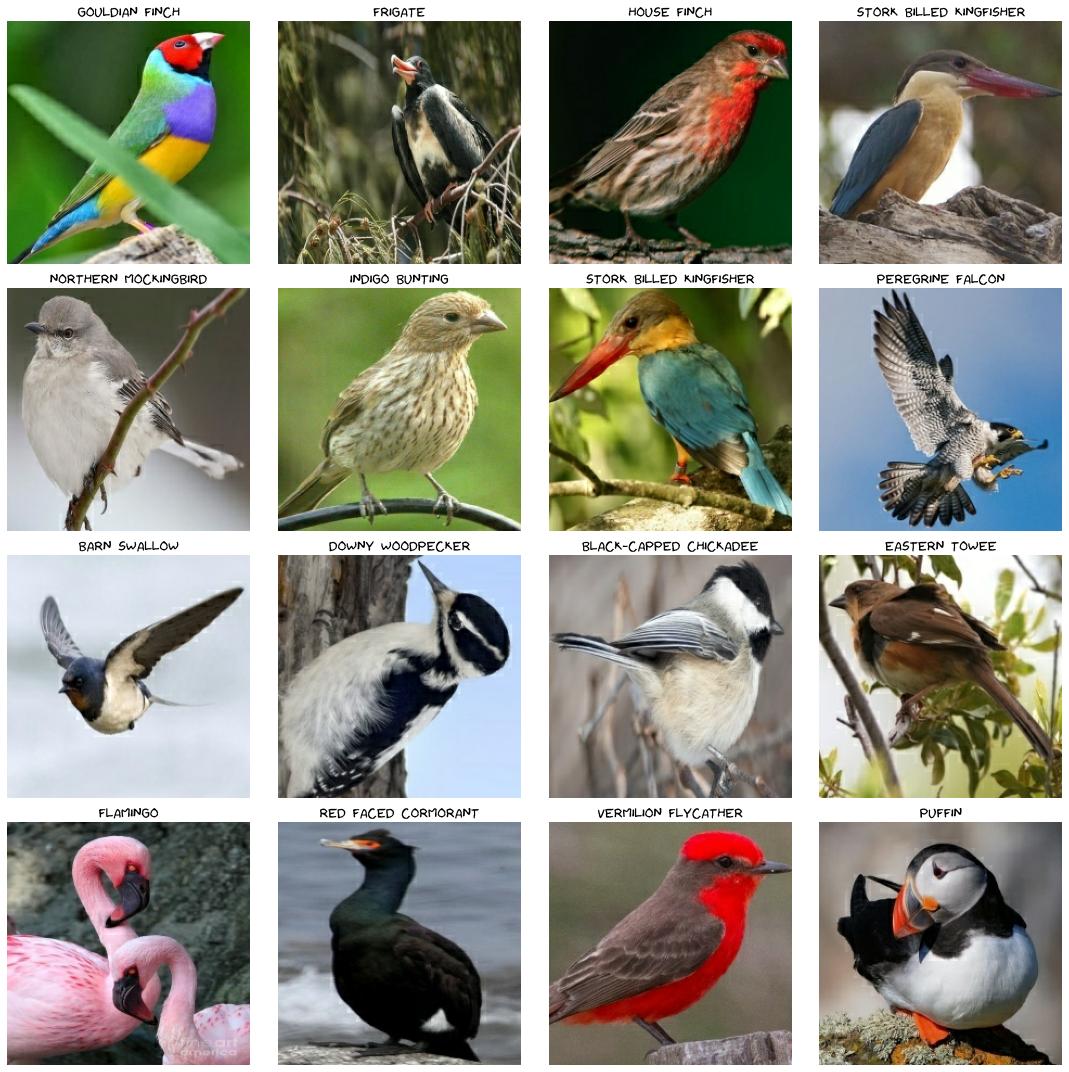

In [53]:
import numpy as np

def display_image(image, title, index):
  with plt.xkcd():
    plt.subplot(4, 4, index)
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.imshow(image)
  
subplot = 441
plt.figure(figsize=(15,15))
i = 1
for image, label_text in dataset.shuffle(16000).take(16):
  display_image(image, label_text.numpy().decode("utf-8"), i)  
  i = i + 1
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()